In [1]:
# Dictate the environment's loctaion of REFPROP
import os
os.environ['RPPREFIX'] = r'C:/Program Files (x86)/REFPROP'

In [2]:
# Import the main class from the Python library
from ctREFPROP.ctREFPROP import REFPROPFunctionLibrary

# Imports from conda-installable packages
import pandas as pd

# Import numpy
import numpy as np

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Import Math for common values such as PI
import math

In [3]:
# Instantiate the library, and use the environment variable to explicitly state which path we want to use.
# As mentioned above, this will be changed to call the correct REFPROP functions to be used
# with MINI-REFPROP and 32-bit python.
# If using MINI-REFPROP and 32-bit python please make the following changes
# RP = REFPROPFunctionLibrary('C:/Program FIles (x86)/MINI-REFPROP\\REFPROP.DLL')
RP = REFPROPFunctionLibrary(os.environ['RPPREFIX'])

In [4]:
# This will call which root directory that will be used for the program. 
RP.SETPATHdll(os.environ['RPPREFIX'])

In [5]:
# Get the unit system we want to use (Mass base SI gives units in
# K, Pa, kg, m, N, J, W, and s)
MASS_BASE_SI = RP.GETENUMdll(0, "MASS BASE SI").iEnum

In [6]:
m_dot = .2 # kg/s

In [7]:
# Tube ID 
Tube_ID_2 = (.25 - 2 * .028) * .0254
Tube_ID_3 = (.5 - 2 * .049) * .0254 
Tube_ID_4 = (.75 - 2 * .083) * .0254 
#Tube_ID_4 = (1 - 2 * .095) * 0.0254 # convert inches to meters

Tube_OD_2 = .25 * .0254 
Tube_OD_3 = .5 * .0254
Tube_OD_4 = .75 * .0254
#Tube_OD_4 = 1 * .0254

In [8]:
# Inlet States
P2 = 2496.259 # psi
P2 = 1236.23
P2 = P2 * 6894.8 # convert psia to Pa
T2 = 80 # C
T2 = T2 + 273.15 # Convert C to Kelvin
T2 = 314.972952

In [9]:
# Obtain fluid properties from the pressure and temperature outlined above
State_2 = RP.REFPROPdll("CO2","PT","H;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P2,T2,[1.0])

# Outputs will be placed into data frame for organization
State_2 = pd.DataFrame(State_2.Output[0:9],
            index = ['Enthalpy [kJ/kg]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg K]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 2'])

In [10]:
P_2 = []
h_2 = []
L2 = []

# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * State_2.loc['Volume [m^3/kg]','State 2'] / (math.pi * Tube_ID_2**2)
Reynolds = State_2.loc['Density [kg/m^3]','State 2'] * Velocity * Tube_ID_2 / State_2.loc['Viscosity [Pa-s]','State 2']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

for k in range(0,11):
    # Using Estimated Length of Tubing used by Heat Source 
    # find the amount of pressure drop caused by fanno flow and Heat addition
    #Length = (1.23573 / (Tube_OD_2 * math.pi))*(k/10) # [meters]
    Length = 1 * (k/10) 

    # Force acted on the wall of tube
    Force = math.pi * Tube_ID_2 * Darcy_f * State_2.loc['Density [kg/m^3]','State 2'] * (Velocity**2) * Length / 8 

    # Dimensionless Friction factor
    f_dim = 4 * Force / (P2 * math.pi * Tube_ID_2**2) 

    # Heat Added into system (kW)
    # Max Heat Possible is 16730 W
    #Q = 16.73*(k/10) # [kW]
    Q = -1*(k/10) # [kW]

    # Dimensionless heating factor
    q_dim = Q * 1000 / (m_dot * State_2.loc['Enthalpy [kJ/kg]', 'State 2'])

    # Inlet Mach Number of length of tubing
    Mach_inlet = Velocity / State_2.loc['Speed of Sound','State 2']

    # Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
    A_eq = ((Mach_inlet**2) * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
            / ((1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim)**2)

    # Find the positive outcome to the biquadratic Mach number
    Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * State_2.loc['CP/CV','State 2'])\
                                + ((1 - 2 * A_eq * (State_2.loc['CP/CV','State 2'] + 1))**0.5))\
                                / ((State_2.loc['CP/CV','State 2'] - 1) - 2 * A_eq * State_2.loc['CP/CV','State 2']**2))
    #Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * State_2.loc['CP/CV','State 2'])\
                                #- ((1 - 2 * A_eq * (State_2.loc['CP/CV','State 2'] + 1))**0.5))\
                               # / ((State_2.loc['CP/CV','State 2'] - 1) - 2 * A_eq * State_2.loc['CP/CV','State 2']**2))

    # Find Outlet pressure caused by fanno flow (frictional loss)
    P3 = P2 * (1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim) / (1 + State_2.loc['CP/CV','State 2']\
                                                                                * (Mach_outlet_1**2))
    P_2.append(P3)
        
    # Find the enthalpy at the outlet of the Heat source
    Enth_3 = (State_2.loc['Enthalpy [kJ/kg]','State 2'] * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
                (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_outlet_1**2))
    h_2.append(Enth_3)
    
    L2.append(2 * (k/10))
            

In [11]:
P_3 = []
h_3 = []
L3 = []

# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * State_2.loc['Volume [m^3/kg]','State 2'] / (math.pi * Tube_ID_3**2)
Reynolds = State_2.loc['Density [kg/m^3]','State 2'] * Velocity * Tube_ID_3 / State_2.loc['Viscosity [Pa-s]','State 2']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

for k in range(0,11):
    # Using Estimated Length of Tubing used by Heat Source 
    # find the amount of pressure drop caused by fanno flow and Heat addition
    #Length = (1.23573 / (Tube_OD_3 * math.pi))*(k/10) # [meters]
    Length = 9.753*(k/10)

    # Force acted on the wall of tube
    Force = math.pi * Tube_ID_3 * Darcy_f * State_2.loc['Density [kg/m^3]','State 2'] * (Velocity**2) * Length / 8 

    # Dimensionless Friction factor
    f_dim = 4 * Force / (P2 * math.pi * Tube_ID_3**2) 

    # Heat Added into system (kW)
    # Max Heat Possible is 16730 W
    #Q = 16.73*(k/10) # [kW]
    Q = -9*(k/10) # [kW]

    # Dimensionless heating factor
    q_dim = Q * 1000 / (m_dot * State_2.loc['Enthalpy [kJ/kg]', 'State 2'])

    # Inlet Mach Number of length of tubing
    Mach_inlet = Velocity / State_2.loc['Speed of Sound','State 2']

    # Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
    A_eq = ((Mach_inlet**2) * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
            / ((1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim)**2)

    # Find the positive outcome to the biquadratic Mach number
    Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * State_2.loc['CP/CV','State 2'])\
                                + ((1 - 2 * A_eq * (State_2.loc['CP/CV','State 2'] + 1))**0.5))\
                                / ((State_2.loc['CP/CV','State 2'] - 1) - 2 * A_eq * State_2.loc['CP/CV','State 2']**2))

    # Find Outlet pressure caused by fanno flow (frictional loss)
    P3 = P2 * (1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim) / (1 + State_2.loc['CP/CV','State 2']\
                                                                                * (Mach_outlet_1**2))
    P_3.append(P3)
        
    # Find the enthalpy at the outlet of the Heat source
    Enth_3 = (State_2.loc['Enthalpy [kJ/kg]','State 2'] * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
                (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_outlet_1**2))
    h_3.append(Enth_3)
    
    L3.append(9.753*(k/10))
            

In [12]:
P_4 = []
h_4 = []
L4 = []

# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * State_2.loc['Volume [m^3/kg]','State 2'] / (math.pi * Tube_ID_4**2)
Reynolds = State_2.loc['Density [kg/m^3]','State 2'] * Velocity * Tube_ID_4 / State_2.loc['Viscosity [Pa-s]','State 2']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

for k in range(0,11):
    # Using Estimated Length of Tubing used by Heat Source 
    # find the amount of pressure drop caused by fanno flow and Heat addition
    #Length = (1.23573 / (Tube_OD_4 * math.pi))*(k/10) # [meters]
    Length = 7.924*(k/10) # [meters]

    # Force acted on the wall of tube
    Force = math.pi * Tube_ID_4 * Darcy_f * State_2.loc['Density [kg/m^3]','State 2'] * (Velocity**2) * Length / 8 

    # Dimensionless Friction factor
    f_dim = 4 * Force / (P2 * math.pi * Tube_ID_4**2) 

    # Heat Added into system (kW)
    # Max Heat Possible is 16730 W
    #Q = 16.73*(k/10) # [kW]
    Q = -9*(k/10) # [kW]

    # Dimensionless heating factor
    q_dim = Q * 1000 / (m_dot * State_2.loc['Enthalpy [kJ/kg]', 'State 2'])

    # Inlet Mach Number of length of tubing
    Mach_inlet = Velocity / State_2.loc['Speed of Sound','State 2']

    # Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
    A_eq = ((Mach_inlet**2) * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
            / ((1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim)**2)

    # Find the positive outcome to the biquadratic Mach number
    Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * State_2.loc['CP/CV','State 2'])\
                                + ((1 - 2 * A_eq * (State_2.loc['CP/CV','State 2'] + 1))**0.5))\
                                / ((State_2.loc['CP/CV','State 2'] - 1) - 2 * A_eq * State_2.loc['CP/CV','State 2']**2))

    # Find Outlet pressure caused by fanno flow (frictional loss)
    P3 = P2 * (1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim) / (1 + State_2.loc['CP/CV','State 2']\
                                                                                * (Mach_outlet_1**2))
    P_4.append(P3)
        
    # Find the enthalpy at the outlet of the Heat source
    Enth_3 = (State_2.loc['Enthalpy [kJ/kg]','State 2'] * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
                (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_outlet_1**2))
    h_4.append(Enth_3)
    
    L4.append(7.924*(k/10))

In [13]:
L2_dim = np.array(L2) / L2[-1]
L3_dim = np.array(L3) / L3[-1]
L4_dim = np.array(L4) / L4[-1]

In [14]:
P_2 = np.array(P_2)/1000
P_3 = np.array(P_3)/1000
P_4 = np.array(P_4)/1000

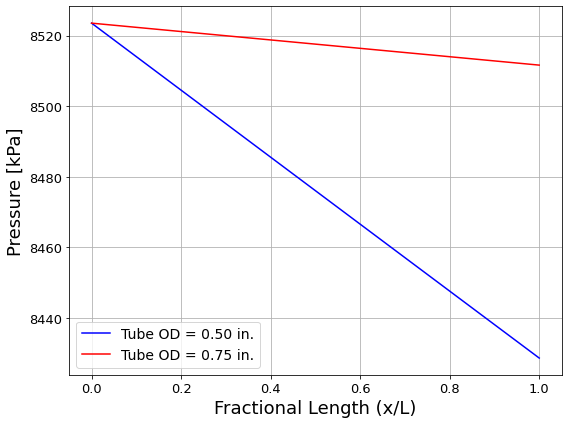

In [21]:
plt.figure(figsize=(8,6), tight_layout=True)

#plt.plot(P_1, linewidth = 1.5 )
#plt.plot(L2_dim, P_2, 'k', linewidth = 1.5 )
plt.plot(L3_dim, P_3, 'b', linewidth = 1.5 )
plt.plot(L4_dim, P_4, 'r', linewidth = 1.5 )
plt.grid(True)
plt.xlabel('Fractional Length (x/L)', fontsize = 18)
plt.ylabel('Pressure [kPa]', fontsize = 18)
plt.legend(['Tube OD = 0.50 in.', 'Tube OD = 0.75 in.', 'Tube OD = .75 in.'], fontsize = 14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

#plt.savefig('Heat_Exchanger_Pressure_Drop_Zoom.png',bbox_inches='tight')

In [16]:
print(L2[-1])
print(L3[-1])
print(L4[-1])

2.0
9.753
7.924


In [17]:
print(P2/1000 - P_2[-1])
print(P2/1000 - P_3[-1])
print(P2/1000 - P_4[-1])

396.2968793031814
94.97692808563806
11.902552141365959


In [18]:
print(h_2[-1]/1000)
print(h_3[-1]/1000)
print(h_4[-1]/1000)

384.56088225156606
346.4077744193452
346.2049221288643
